In [1]:
import os
import random
import time
import glob
import json
import dit
import itertools
import time
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
os.chdir("../")
from helpers.group_helpers import classify_syms, srv_to_mat
from helpers.compare_helpers import appendtoPXS,load_frame,addbestsym
from jointpdfpython3.measures import synergistic_entropy_upper_bound, append_random_srv
from jointpdfpython3.params_matrix import params2matrix_incremental,matrix2params_incremental
from jointpdfpython3.JointProbabilityMatrix import JointProbabilityMatrix
from syndisc.syndisc import self_disclosure_channel
os.chdir("./plot_notebooks")
import seaborn as sns;sns.set()

In [2]:
def costfunc(srvparams,jXS,lenJXS,parX,subjects,upper):
    params2matrix_incremental(jXS,parX+list(srvparams))
    totmi = jXS.mutual_information(subjects,[lenJXS-1])
    indivmis = sum([jXS.mutual_information([i],[lenJXS-1]) for i in subjects])
    cost=abs((upper-(totmi-indivmis))/upper)
    if totmi != 0:
        return cost+((indivmis/totmi))
    else:
        return cost+(indivmis)

minimize_options = {'ftol': 1e-6}
def symsyninfo(states,lenX,jX,syms,initialtype='first',costf=costfunc,verbose=None):
    subjects = list(range(lenX))
    parX = matrix2params_incremental(jX)
    upper = synergistic_entropy_upper_bound(jX)
    jXS = append_random_srv(jX,parX,1)
    lenJXS = len(jXS)
    bestsymid=-1
    # get initial guess of best sym
    if initialtype!='random':
        if initialtype=='first':
            syms=[syms[0]]
        pXSym,bestsymid = addbestsym(lenX,jX,upper,syms)
        jXS.joint_probabilities.joint_probabilities = pXSym

    freeparams = (states**(lenJXS))-(states**(len(jX)))
    symparams = matrix2params_incremental(jXS)[-freeparams:]
    optres_ix = minimize(costf,
                            symparams,
                            bounds=[(0.0, 1.0)]*freeparams,
                            callback=(lambda xv: param_vectors_trace.append(list(xv))) if verbose else None,
                            args=(jXS,lenJXS,parX,subjects,upper),options=minimize_options)
    params2matrix_incremental(jXS,parX+list(optres_ix.x))
    return bestsymid,jXS

states=3
lenX=2
subjects = np.arange(lenX)

if states == 5:
    print("LOAD LOWER ORDER AND FULL ONLY")
    with open('../../results/sudokus/permutation_sudokus_states'+str(states)+'.npy', 'rb') as f:
        fullsyms = np.load(f,allow_pickle=True)
        syms = list(fullsyms)
    with open('../../results/sudokus/lowerorder_sudokus_states'+str(states)+'.pkl', 'rb') as f:
        lowerorders=pickle.load(f)
        syms = syms+list(lowerorders)
    syms=np.array(syms)
else:
    with open('../../results/sudokus/constructedSRVstates'+str(states)+'.npy', 'rb') as f:
        syms = np.load(f,allow_pickle=True)

l, cs = classify_syms(syms,states)
if states==2:
    cs['noisy sym'] = cs['lower order sym']
    del cs['lower order sym']
cs

{'full sym': [0, 1],
 'noisy sym': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 'oversized states 4': [16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63],
 'oversized states 5': [64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113]}

In [ ]:
data = {'systemID':[],'parX':[],'upper':[],'totmi':[],'indivmi':[],'runtime':[],'exp_sort':[]}
types = ['random','full','bestofall']
samples = 200
cursyms = syms
for i in range(samples):
    print(i,time.strftime("%H:%M:%S", time.localtime()))
    jX = JointProbabilityMatrix(lenX,states)
    upper = synergistic_entropy_upper_bound(jX)
    pX = jX.joint_probabilities.joint_probabilities
    parX = matrix2params_incremental(jX)
    for t in types:
        if t !='syndisc':
            if t == 'full':
                cursyms = syms[cs['full sym']]
            elif t == 'bestofall':
                cursyms = syms[cs['full sym']+cs['noisy sym']]
            else:
                cursyms = syms
            
            before = time.time()
            best, jXS = symsyninfo(states,lenX,jX,\
                   cursyms,initialtype=t,costf=costfunc)
            data['runtime'].append(time.time()-before)
            data['indivmi'].append(sum([jXS.mutual_information([s],[lenX]) for s in subjects]))
            data['totmi'].append(jXS.mutual_information(subjects,[lenX]))
            data['exp_sort'].append(t)
            data['systemID'].append(i)
            data['upper'].append(upper)
            data['parX'].append(parX)
        else:
            ditjX = dit.Distribution.from_ndarray(pX)
            before = time.time()
            syn, probs = self_disclosure_channel(ditjX)
            data['runtime'].append(time.time()-before)
            data['indivmi'].append(0)
            data['totmi'].append(syn)
            data['exp_sort'].append(t)
            data['systemID'].append(i)
            data['upper'].append(upper)
            data['parX'].append(parX)

initialdata = pd.DataFrame(data=data)
initialdata.to_pickle("../../results/test/finalinitialcomparison"+str(states)+".pkl") 
initialdata

0 15:47:32


C:\Users\enrik\Desktop\Mabomba\Studie\MasterCS\Thesis\code\jointpdfpython3\JointProbabilityMatrix.py:527: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item == 'all':


In [36]:
# syns = initialdata[initialdata['exp_sort']=='random']
# pars = syns['parX']

# types = ['bestofall']
# cursyms = syms[cs['full sym']+cs['noisy sym']]

# for i,p in enumerate(pars):
#     print(i,time.strftime("%H:%M:%S", time.localtime()))
#     jX = JointProbabilityMatrix(lenX,states)
#     params2matrix_incremental(jX,p)
#     pX = jX.joint_probabilities.joint_probabilities
#     upper = synergistic_entropy_upper_bound(jX)
#     for t in types:
#         if t !='syndisc':
#             before = time.time()
#             best, jXS = symsyninfo(states,lenX,jX,\
#                    cursyms,initialtype=t)
#             data['runtime'].append(time.time()-before)
#             data['indivmi'].append(sum([jXS.mutual_information([s],[lenX]) for s in subjects]))
#             data['totmi'].append(jXS.mutual_information(subjects,[lenX]))
#         else:
#             ditjX = dit.Distribution.from_ndarray(pX)
#             before = time.time()
#             syn, probs = self_disclosure_channel(ditjX)
#             data['runtime'].append(time.time()-before)
#             data['indivmi'].append(0)
#             data['totmi'].append(syn)
#         data['exp_sort'].append(t)
#         data['systemID'].append(i)
#         data['upper'].append(upper)
#         data['parX'].append(p)

# initialdata = pd.DataFrame(data=data)
# initialdata.to_pickle("../../results/test/initialsymbestofallstates"+str(states)+".pkl") 


## plot initial syms

../../results/rq31\finalinitialcomparison2.pkl
../../results/rq31\finalinitialcomparison3.pkl
../../results/rq31\finalinitialcomparison5.pkl
../../results/rq31\initialsymbestofallstates4.pkl
../../results/rq31\initialsymcomparison4.pkl


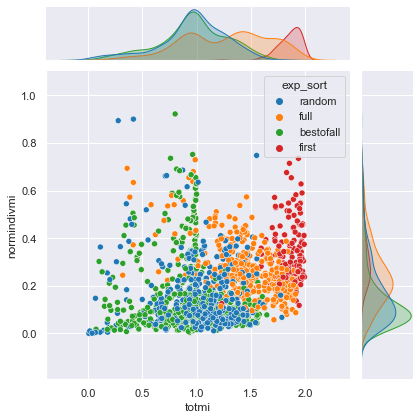

In [22]:
# load symSRVs for number of states
folder = '../../results/rq31/'
os.chdir(folder)
files = glob.glob(folder+"*.pkl")
ds = []
if len(files) != 0:
    for f in files:
        print(f)
        cur = pd.read_pickle(f)
        cur['states'] = f[-5]
        ds.append(cur)

d = pd.concat(ds)
os.chdir('../../code/plot_notebooks')
d = d[d['exp_sort']!='syndisc']
d['normindivmi']=d['indivmi']/d['totmi']
sns.jointplot(data=d,x='totmi',y='normindivmi',hue='exp_sort',palette='tab10')

Text(0.5, 1.0, 'states=3')

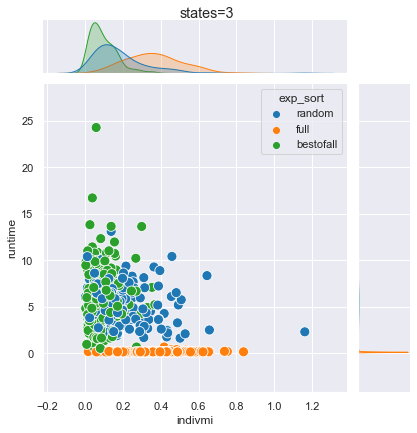

In [40]:
new = pd.read_pickle("../../results/test/finalinitialcomparison"+str(states)+".pkl")
# new = new.drop(new.index[[0]])
# old = pd.read_pickle("../../results/initialsym/initialsymcomparison4.pkl")
# old = old.drop(old.index[[0]])
# plot = pd.concat([old,new])
# plot = plot[(plot['exp_sort']=='random')|(plot['exp_sort']=='bestofall')]
plot=new
# sns.jointplot(data=plot,x='runtime',y='indivmi',hue='exp_sort')
ax=sns.jointplot(data=plot,x='indivmi',y='runtime',hue='exp_sort',palette='tab10',s=100)
ax.fig.suptitle("states="+str(states),y=1.0)


## Compare scores optimized sym vs syndisc vs initial gues...

In [10]:
# plot=d
# valuevars = ['syn_info','symwms']
# plotmelt = pd.melt(plot, id_vars=['systemID','syn_upper','I(X1;X2)',\
#                                   'I(Xi;S)','I(Xi;initialsym)'], value_vars=valuevars,
#            var_name='exp_sort', value_name='WMS')

# # valuevars = ['WMS(X;S)','normsymwms']
# # plotmelt2 = pd.melt(plot, id_vars=['systemID','syn_upper','I(X1;X2)',\
# #                                   'I(Xi;S)','I(Xi;initialsym)'], value_vars=valuevars,
# #            var_name='exp_sort', value_name='normWMS')

# valuevars = ['I(Xi;S)','I(Xi;initialsym)']
# plotmelt3 = pd.melt(plot, id_vars=['systemID','syn_upper','I(X1;X2)'], value_vars=valuevars,
#            var_name='exp_sort', value_name='indivmi')

# plot = plotmelt3
# # plot['normWMS']=plotmelt2['normWMS']
# plot['WMS'] = plotmelt['WMS']

# tol = 0.01
# plot=plot[plot['indivmi']<tol]
# plot

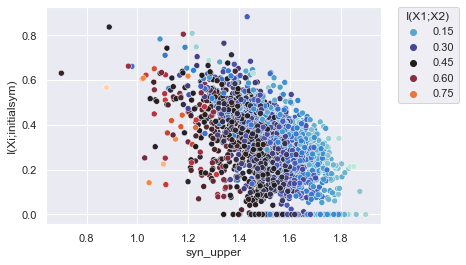

In [11]:
hue='I(X1;X2)'
sns.scatterplot(data=d,x='syn_upper',y='I(Xi;initialsym)',hue=hue,palette='icefire')
# sns.lineplot(data=d,x='syn_upper',y='syn_upper',color='grey')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.01,title=hue)
